In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, sampler
from tqdm import tqdm, trange
from transformers import (RobertaTokenizer, RobertaConfig, RobertaModel,
                          AdamW, get_linear_schedule_with_warmup)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, logging, re, random

from ResNet import ResNet
from GoogLeNet import GoogLeNet
from VGG16 import VGG16
from Combination import CombinedModel, CrossEntropy

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
checkpoint = "roberta-base"
checkpointxlm = "xlm-roberta-base"

In [2]:
class RawExample:
    def __init__(self, idx = None, text = None, img = None, label = None):
        self.idx = idx
        self.text = text
        self.img = img
        self.label = label
    def setText(self, text):
        self.text = text
    def setImg(self, img):
        self.img = img
    def setLabel(self, label):
        self.label = label

def ReadRaw(Xpath, ypath, test_path, num, standard_img_shape = (256, 256)):
    train, test = [], []
    flist = os.listdir(Xpath)
    dic = {"positive": 0, "negative": 1, "neutral": 2}
    labels = np.zeros((num,), dtype = np.int64)
    train_idx, test_idx = [], []
    with open(ypath) as f:
        lines = f.read().split("\n")[1:]
        for line in lines:
            idx, label = line.split(",")
            labels[int(idx) - 1] = dic[label]
            train_idx += [int(idx)]
    with open(test_path) as f:
        lines = f.read().split("\n")[1:]
        for line in lines:
            idx, label = line.split(",")
            test_idx += [int(idx)]
    for i in range(len(flist) // 2):
        fn_img, fn_text = flist[2 * i:2 * i + 2]
        idx = int(fn_img.split(".")[0])
        try:
            with open(os.path.join(Xpath, fn_text), "r+", encoding = "utf-8") as t:
                text = t.read().strip()
        except:
            with open(os.path.join(Xpath, fn_text), "r+", encoding = "ANSI") as t:
                text = t.read().strip()
        finally:
            img = cv2.imread(os.path.join(Xpath, fn_img))
            img = cv2.resize(img, standard_img_shape, interpolation = cv2.INTER_NEAREST)
            img = np.array(img).transpose(2,1,0)
            text = re.sub('RT @\w+:', '.', text)
            if idx in train_idx:
                item = RawExample(idx, text, img, labels[idx - 1])
                train += [item]
            elif idx in test_idx:
                item = RawExample(idx, text, img)
                test += [item]

    return train, test, test_idx

In [3]:
def set_seed(seed=2022):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 idx,
                 source_ids,
                 source_mask,
                 img,
                 label

    ):
        self.idx = idx
        self.source_ids = source_ids
        self.source_mask = source_mask
        self.img = img
        self.label = label

def convert_examples_to_features(examples, tokenizer, max_source_length = 128):
    features = []
    for example_index, example in enumerate(examples):
        # only source
        source_tokens = tokenizer.tokenize(example.text)[:max_source_length-2]
        source_tokens =[tokenizer.cls_token] + source_tokens + [tokenizer.sep_token]
        source_ids =  tokenizer.convert_tokens_to_ids(source_tokens) 
        source_mask = [1] * (len(source_tokens))
        padding_length = max_source_length - len(source_ids)
        source_ids+=[tokenizer.pad_token_id]*padding_length
        source_mask+=[0]*padding_length
       
        features.append(
            InputFeatures(
                 example.idx,
                 source_ids,
                 source_mask,
                 example.img,
                 example.label
            )
        )
        
        if example_index < 3:
            print_img = example.img.transpose(2, 1, 0)[:,:,::-1]
            plt.imshow(print_img)
            plt.show()
        
    return features

In [17]:
source_length = 64
MAX_INDEX = 5129
train_batch_size = 16
eval_batch_size = 16
NUM_TRAIN = 3500
NUM_ALL = 4000
NUM_DEV = 500
lr = 2e-05
weight_decay = 1e-05
num_train_epochs = 10
adam_epsilon = 1e-08

device = torch.device("cuda")

output_file = "./test_without_label.txt"
model_path = "./pretrained_model/roberta-base"
model_path_xlm = "./pretrained_model/xlm-roberta-base"

In [5]:
tokenizer_class, config_class, model_class = RobertaTokenizer, RobertaConfig, RobertaModel
config = RobertaConfig.from_pretrained(model_path)
tokenizer = tokenizer_class.from_pretrained(checkpoint)

In [16]:
set_seed(seed=712)
nl_encoder = model_class.from_pretrained(model_path)
# img_encoder = ResNet(3, 256, 3)
img_encoder = GoogLeNet(3, 256, 3)
# img_encoder = VGG16(3)
model = CombinedModel(img_encoder, nl_encoder, 3)
model.to(device)
loss_func = CrossEntropy()
loss_func.to(device)

Some weights of the model checkpoint at ./pretrained_model/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CrossEntropy(
  (loss_func): CrossEntropyLoss()
)

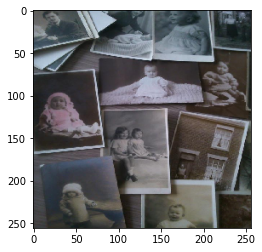

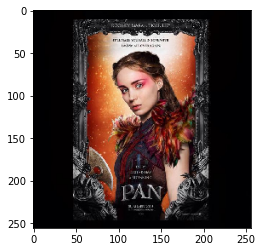

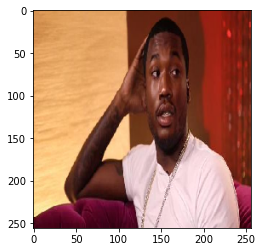

In [36]:
train_examples, test_examples, test_idx = ReadRaw("./data/data", "data/train.txt", "./data/test_without_label.txt", MAX_INDEX)
random.shuffle(train_examples)
# train features
train_features = convert_examples_to_features(train_examples, tokenizer, source_length)
all_source_ids = torch.tensor([f.source_ids for f in train_features], dtype=torch.long)
all_source_mask = torch.tensor([f.source_mask for f in train_features], dtype=torch.long)
all_img = torch.tensor([f.img for f in train_features], dtype=torch.float32)
all_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_source_ids, all_source_mask, all_img, all_labels)

train_dataloader = DataLoader(train_data,  batch_size = train_batch_size,
                              sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
dev_dataloader = DataLoader(train_data,  batch_size = eval_batch_size,
                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_ALL)))

del train_examples, train_features, train_data

In [18]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
t_total = len(train_dataloader) // 1 * num_train_epochs
optimizer = optim.AdamW(optimizer_grouped_parameters, lr=lr, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(t_total*0.1),
                                            num_training_steps=t_total)

In [19]:
#Start training
logger.info("***** Running training *****")
logger.info("  Num examples = %d", NUM_TRAIN)
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num epoch = %d", num_train_epochs)


model.train()
nb_tr_examples, nb_tr_steps,tr_loss,global_step,best_acc,best_model = 0, 0, 0, 0, 0, None
for epoch in range(num_train_epochs):
    bar = tqdm(train_dataloader,total=len(train_dataloader))
    for batch in bar:
        batch = tuple(t.to(device) for t in batch)
        source_ids,source_mask,img,labels = batch
        img /= 255
        logits = model(img=img,src_ids=source_ids,src_mask=source_mask)
        loss = loss_func(logits, labels)

        tr_loss += loss.item()
        train_loss = round(tr_loss / (nb_tr_steps + 1), 4)
        bar.set_description("epoch {} loss {}".format(epoch+1,train_loss))
        nb_tr_examples += source_ids.size(0)
        nb_tr_steps += 1
        loss.backward()

        #Update parameters
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        global_step += 1
        
    logger.info("\n***** Running evaluation *****")
    logger.info("  Num examples = %d", NUM_DEV)
    logger.info("  Batch size = %d", eval_batch_size)

    num_correct, num_all = 0, 0
    with torch.no_grad():
        for batch in tqdm(dev_dataloader,total=len(dev_dataloader)):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, img, labels = batch
            img /= 255
            logits = model(img=img,src_ids=source_ids,src_mask=source_mask)
            preds = logits.argmax(1)
            num_correct += (labels == preds).sum().item()
            num_all += preds.size(0)
    acc = num_correct / num_all
    if acc >= best_acc:
        best_acc = acc
        best_model = model

    logger.info("  Num all = %d, Num correct = %d, Accuracy = %.1f",
                num_all, num_correct, num_correct / num_all * 100)
    logger.info("  "+"*"*20)
                

07/11/2022 17:45:31 - INFO - __main__ -   ***** Running training *****
07/11/2022 17:45:31 - INFO - __main__ -     Num examples = 3500
07/11/2022 17:45:31 - INFO - __main__ -     Batch size = 16
07/11/2022 17:45:31 - INFO - __main__ -     Num epoch = 10
epoch 1 loss 0.8991: 100%|███████████████████████████████████████████████████████████| 219/219 [01:22<00:00,  2.67it/s]
07/11/2022 17:46:53 - INFO - __main__ -   
***** Running evaluation *****
07/11/2022 17:46:53 - INFO - __main__ -     Num examples = 500
07/11/2022 17:46:53 - INFO - __main__ -     Batch size = 16
100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.51it/s]
07/11/2022 17:46:57 - INFO - __main__ -     Num all = 500, Num correct = 323, Accuracy = 64.6
07/11/2022 17:46:57 - INFO - __main__ -     ********************
epoch 2 loss 0.7984: 100%|███████████████████████████████████████████████████████████| 219/219 [01:34<00:00,  2.31it/s]
07/11/2022 17:48:32 - INFO - _

In [34]:
logger.info("\n***** Running evaluation *****")
logger.info("  Num examples = %d", NUM_DEV)
logger.info("  Batch size = %d", eval_batch_size)

num_correct, num_all = 0, 0
with torch.no_grad():
    for batch in tqdm(dev_dataloader,total=len(dev_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        source_ids, source_mask, img, labels = batch
        img /= 255
        logits = best_model(img=img,src_ids=source_ids,src_mask=source_mask)
        preds = logits.argmax(1)
        num_correct += (labels == preds).sum().item()
        num_all += preds.size(0)

logger.info("  Num all = %d, Num correct = %d, Accuracy = %.1f",
            num_all, num_correct, num_correct / num_all * 100)
logger.info("  "+"*"*20)

07/11/2022 18:06:08 - INFO - __main__ -   
***** Running evaluation *****
07/11/2022 18:06:08 - INFO - __main__ -     Num examples = 500
07/11/2022 18:06:08 - INFO - __main__ -     Batch size = 16
100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.50it/s]
07/11/2022 18:06:12 - INFO - __main__ -     Num all = 500, Num correct = 365, Accuracy = 73.0
07/11/2022 18:06:12 - INFO - __main__ -     ********************


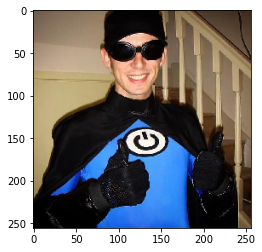

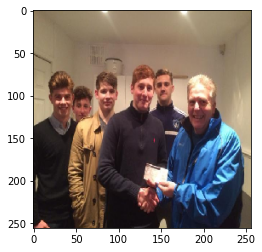

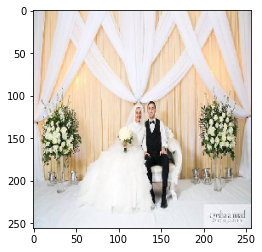

In [37]:
test_features = convert_examples_to_features(test_examples, tokenizer, source_length)
all_source_ids = torch.tensor([f.source_ids for f in test_features], dtype=torch.long)
all_source_mask = torch.tensor([f.source_mask for f in test_features], dtype=torch.long)
all_img = torch.tensor([f.img for f in test_features], dtype=torch.float32)
all_idx = torch.tensor([f.idx for f in test_features], dtype=torch.long)
test_data = TensorDataset(all_source_ids, all_source_mask, all_img, all_idx)

test_dataloader = DataLoader(test_data, batch_size = eval_batch_size, shuffle = False)
del test_examples, test_features, test_data

In [38]:
logger.info("\n***** Running evaluation *****")
logger.info("  Num examples = %d", NUM_DEV)
logger.info("  Batch size = %d", eval_batch_size)

dic = ["positive", "negative", "neutral"]
num_correct, num_all, res_dict = 0, 0, {}
with torch.no_grad():
    for batch in tqdm(test_dataloader,total=len(dev_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        source_ids, source_mask, img, idx = batch
        img /= 255
        logits = best_model(img=img,src_ids=source_ids,src_mask=source_mask)
        preds = logits.argmax(1)
        for i, pred in zip(idx, preds):
            res_dict[int(i.detach())] = dic[pred]

logger.info("  "+"*"*20)
logger.info("\n***** Writing results *****")
logger.info("  File = %s", output_file)

with open(output_file, 'w+') as f:
    f.write("guid,tag\n")
    for idx in test_idx:
        f.write(str(idx) + "," + res_dict[idx] + "\n")

07/11/2022 18:08:41 - INFO - __main__ -   
***** Running evaluation *****
07/11/2022 18:08:41 - INFO - __main__ -     Num examples = 500
07/11/2022 18:08:41 - INFO - __main__ -     Batch size = 16
100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.69it/s]
07/11/2022 18:08:45 - INFO - __main__ -     ********************
07/11/2022 18:08:45 - INFO - __main__ -   
***** Writing results *****
07/11/2022 18:08:45 - INFO - __main__ -     File = ./test_without_label.txt
